In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-23 18:04:12--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2020-04-23 18:04:12 (28.8 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



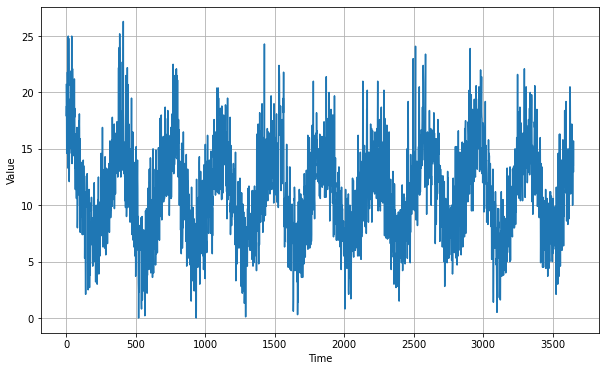

In [8]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  count = 0
  for row in reader:
    count +=1
    time_step.append(float(count))
    temps.append(float(row[1]))
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
series[1:10]
time[1:10]

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [0]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time]  # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
len(x_valid)

1150

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast
    # YOUR CODE HERE

In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda

model = tf.keras.models.Sequential()
model.add(Conv1D(32, 5, padding='causal', strides=1, activation='relu', input_shape=[None, 1]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.add(Lambda(lambda x: x*10))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 21ms/step - loss: 10.3978 - mae: 10.8960 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 10.3813 - mae: 10.8950 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 10.3955 - mae: 10.8936 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 10.4133 - mae: 10.8919 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 10.3915 - mae: 10.8899 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 10.4032 - mae: 10.8876 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 10.3836 - mae: 10.8850 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 10.3726 - mae: 10.8821 - l

(1e-08, 0.0001, 0.0, 60.0)

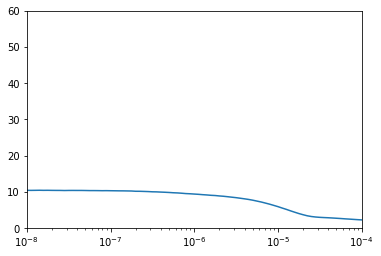

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential()
model.add(Conv1D(64, 3, padding='causal', strides=1, activation='relu', input_shape=[None, 1]))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.add(Lambda(lambda x: x*10))

optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 0s 17ms/step - loss: 3.7853 - mae: 4.2943
Epoch 2/50
25/25 [==============================] - 0s 15ms/step - loss: 2.0016 - mae: 2.4592
Epoch 3/50
25/25 [==============================] - 0s 15ms/step - loss: 1.7832 - mae: 2.2329
Epoch 4/50
25/25 [==============================] - 0s 15ms/step - loss: 1.7310 - mae: 2.1813
Epoch 5/50
25/25 [==============================] - 0s 15ms/step - loss: 1.6919 - mae: 2.1407
Epoch 6/50
25/25 [==============================] - 0s 15ms/step - loss: 1.6562 - mae: 2.1043
Epoch 7/50
25/25 [==============================] - 0s 14ms/step - loss: 1.6252 - mae: 2.0732
Epoch 8/50
25/25 [==============================] - 0s 14ms/step - loss: 1.6009 - mae: 2.0488
Epoch 9/50
25/25 [==============================] - 0s 15ms/step - loss: 1.5919 - mae: 2.0393
Epoch 10/50
25/25 [==============================] - 0s 16ms/step - loss: 1.5555 - mae: 2.0000
Epoch 11/50
25/25 [==============================] - 0s 15m

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

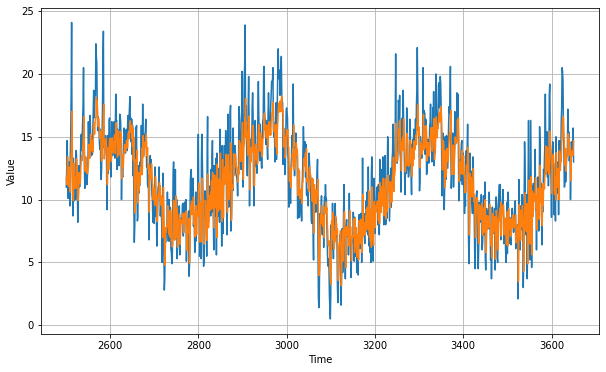

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [56]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7943196

In [57]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TENS

[11.746978 11.200022 12.432694 ... 13.507024 13.557085 14.682855]
